<h1>Lab Five: Wide and Deep Networks</h1>
<b>By Michael Watts, Maya Muralidhar, Nora Potenti, and Adam Ashcraft </b>

<h2> 1.0 Preparation </h2>

<h3> 1.1 Business Understanding </h3>

Our data set for this lab is a collection of synthetic online transactions produced by The PaySim simulator and collected by the Norwegian University of Science and Technology. The simulation was created based on real financial data for a multinational company. It is categorized by the type of the transaction (i.e. a payment, transfer, etc.), the original balance before and after the transaction of the source account, the balance before and after the transaction of the destination account, and if the transaction was actually fraud. It is also marked by several other categories not useful for this use case. As more and more transactions shift from the physical space to the digital space, it becomes more important for financial institutions to be able to detect and deny fraudulent charges. As the number of digital transactions increases, the amount of data to parse to determine the legitimacy of a transaction increases to the point where these companies could not afford humans to do the fraud detection. This is where our model would come in, as an efficient learning tool able to detect and mark fraud for these institutions. Romexsoft, a company that helps develop fraud detection models, boast a 98% fraud detection rate. For our model to be a success, it must detect at or above this rate. 
<hr>
Kaggle link: https://www.kaggle.com/ntnu-testimon/paysim1/home  <br>
Romexsoft: https://www.romexsoft.com/blog/credit-card-fraud-detection-in-banking/

<h3> 1.2 Data Cleaning </h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import pickle
import warnings
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from scipy.special import expit
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import missingno as mn
import sys

In [2]:
finData = pd.read_csv('data/PS_20174392719_1491204439457_log.csv') #load the data
finData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


Let's begin by removing some of the columns we will not be using. After this, we will convert the oldbalanceOrg and newbalanceOrig into one column that reflects the change the original account balance, called Org_Account_Delta. If it is an increase in account balance, we will make it a 1. If it is a decrease we will make it a negative 1. No change will be a 0. We will do the same thing for oldbalanceDest and newbalanceDest in Dest_Account_Delta. Finally, we will encode the one-hot encode the 6 types: CASH-IN, CASH-OUT, NAN, DEBIT, PAYMENT and TRANSFER. If a transaction is fraudulent, in the isFraud column, it will be marked as 1.

In [3]:
finData.drop(columns=['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], inplace=True)
def calcChange1(row):
    change = row.newbalanceOrig - row.oldbalanceOrg
    if(change > 0):
        return int(1)
    if(change < 0):
        return int(-1)
    if(change == 0):
        return int(0)
def calcChange2(row):
    change = row.newbalanceDest - row.oldbalanceDest
    if(change > 0):
        return int(1)
    if(change < 0):
        return int(-1)
    if(change == 0):
        return int(0)
finData['Org_Account_Delta'] = finData.apply(calcChange1, axis=1)
finData['Dest_Account_Delta'] = finData.apply(calcChange2, axis=1)
finData.drop(columns=['newbalanceOrig', 'newbalanceDest'], inplace=True)
def setType(x):
    if x == 'CASH-IN':
        return int(0)
    if x == 'CASH-OUT':
        return int(1)
    if x == 'DEBIT':
        return int(2)
    if x == 'PAYMENT':
        return int(3)
    if x == 'TRANSFER':
        return int(4)
    else:
        return int(5)
finData['type'] = finData['type'].apply(setType)
finData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 7 columns):
type                  int64
amount                float64
oldbalanceOrg         float64
oldbalanceDest        float64
isFraud               int64
Org_Account_Delta     int64
Dest_Account_Delta    int64
dtypes: float64(3), int64(4)
memory usage: 339.8 MB


Now let's pickle our data for faster reterival. 

In [4]:
pickle.dump(finData, open( 'pickledData/finData.p', 'wb' ))

In [5]:
finData = pickle.load(open( 'pickledData/finData.p', 'rb' ))

In [6]:
finData.head()

,type,amount,oldbalanceOrg,oldbalanceDest,isFraud,Org_Account_Delta,Dest_Account_Delta
0,3,9839.64,170136.0,0.0,0,-1,0
1,3,1864.28,21249.0,0.0,0,-1,0
2,4,181.00,181.0,0.0,1,-1,0
3,5,181.00,181.0,21182.0,1,-1,-1
4,3,11668.14,41554.0,0.0,0,-1,0


<module 'missingno' from 'C:\\Users\\mayam\\Anaconda3\\lib\\site-packages\\missingno\\__init__.py'>


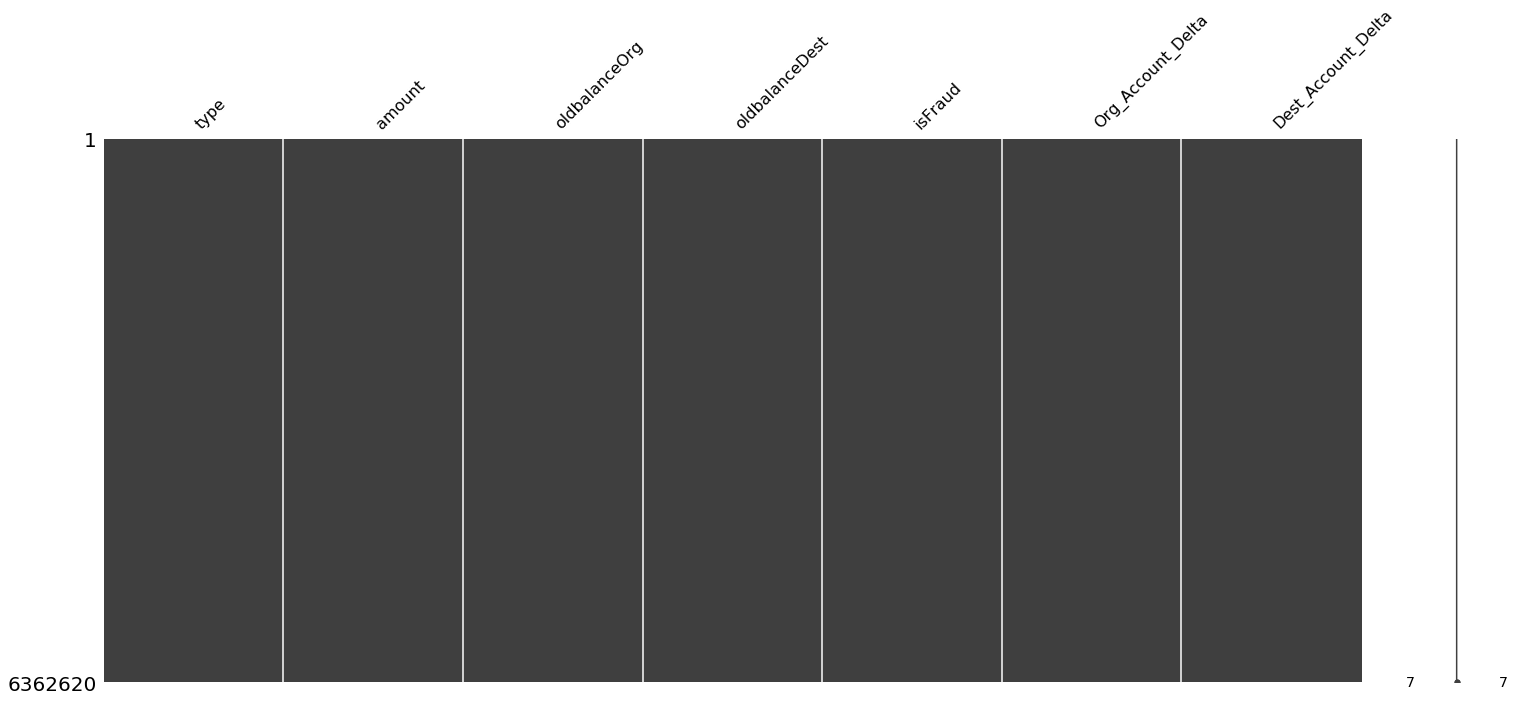

In [7]:
mn.matrix(finData)
print(mn)

We now have no missing data that needs to be imputed. We have our Y target, isFraud. We also have the type of transaction and the amount of each transaction. We have generated columns to show the change in each account with each transaction as well. Finally, we also know the account balance for the origin and destination accounts before each transaction. 

<h3> 1.3 Cross-Product Features </h3>

First, we would recommend crossing oldbalanceOrg with Dest_Account_Delta. This could reveal a correlation between accounts with high initial balances and increases in destination account balances. Scammers would logically want to target accounts with high balances as these accounts would have the most to possible steal. We could also cross amount, type, and Dest_Account_Delta. A scammer would want to have the biggest transactions possible that do not raise alarms with the banks. Most banks would have similar metrics for this, leaving the largest possible fraudulent transaction hovering around a similar safe value. Scammers may also favor certain types of transfer that would have higher potential limits. There could be a correlation between this value appearing, the method of transfer, and money transferred into destination accounts which implies fraud. Finally, we will cross oldbalanceOrg and oldbalanceDest. A scammer may open up new accounts with low balances under fake names and using these accounts to hold the money from the targeted high vauled real accounts. This will show us if there is a correlation in transactions between high source accounts and low scammer bank accounts.
 


In [8]:
cross_product_sets= [['oldbalanceOrg', 'Dest_Account_Delta'], 
                     ['amount', 'type', 'Dest_Account_Delta'], 
                    ['oldbalanceOrg', 'oldbalanceDest']]

<h3> 1.4 Evaluation Criteria </h3>

For our evaluation criteria, we will be focused on recall. Recall focuses on the amount of false negatives achieved. In this instance a false negative means marking a fraudulent transaction as a genuine one. A false positive means we have marked a genuine transaction as a fraudulent one. In a false positive scenario, the client may be slightly inconvenienced. He would have to call the bank and ensure the proper funds are released. In a false negative situation, the client’s money has been illegally transferred from his account and is most likely lost to him forever. The bank will have to spend time both reimbursing his account and filing the proper paperwork about the fraudulent attempt. The client will be unhappy the bank has not properly secured his money and the criminal has just successful conned the bank. In order to prevent what would be the worse case scenario for a mislabeled transaction, we will focus on keeping our recall and subsequently our false negative rate low.


In [9]:
my_scorer = make_scorer(recall_score)

<h3> 1.5 Data Division <h3>

For our data, we will use a stratified shuffle split. The stratification of the data ensures that each k-fold will have the same percentage of fraudulent data as the data set as a whole. This prevents the model from ever receiving and being trained off of a data set with no fraudulent transactions present. If this were the case, our network may simply detect everything as genuine and still have a good evaluation score. shuffling will prevent any one account from being disproportionally present in a fold. As this data was originally linear time data, it is possible one account would be making several hundreds of transactions sequentially. For instance, a company may be restocking all its inventory at once. To avoid this, we will shuffle the data. While 10 splits would have been the best choice, for the sake of computation, we will bound it with 5 folds. 


In [10]:
#first we will divide out our X and Y data
y = finData.isFraud
finData.drop(columns=['isFraud'], inplace=True)
X = finData
cv = StratifiedShuffleSplit(n_splits=5, random_state=1) 
# X_train_set = []
# X_test_set = []
# y_train_set = []
# y_test_set = []
# numerical_headers = ['amount', 'oldbalanceOrg', 'oldbalanceDest']
# for train_index, test_index in cv.split(X, y): 
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     y_train_set.append(y_train)
#     y_test_set.append(y_test)
#     for col in numerical_headers: #scale our data
#         ss = StandardScaler()
#         X_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))
#         X_test[col] = ss.transform(df_test[col].values.reshape(-1, 1))
#     X_train_set.append(X_train)
#     X_test_set.append(X_test)

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.layers import Embedding, Flatten, Concatenate
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import scipy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print(X_train.shape)
X_train = scipy.sparse.csr_matrix(X_train.values)
X_test = scipy.sparse.csr_matrix(X_test.values)
y_train = y_train.values
y_test = y_test.values
X_train.shape

(5090096, 6)


(5090096, 6)

In [25]:
inputs = Input(shape=(X_train.shape[1],), sparse=True)

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(units=10, activation='relu')(inputs)
predictions = Dense(1,activation='sigmoid')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)

In [ ]:
import tensorflow as tf
# From Stack Overflow: 
# https://stackoverflow.com/questions/43076609/how-to-calculate-precision-and-recall-in-keras
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=[as_keras_metric(tf.metrics.recall)])
model.fit(X_train, y_train, epochs=10, batch_size=50, verbose=1)
from sklearn import metrics as mt
yhat_proba = model.predict(X_test)
yhat = np.round(yhat_proba)
print(mt.confusion_matrix(y_test,yhat), recall_score(y_test, y_hat, average='macro'))

Epoch 1/10
3005050/5090096 [================>.............] - ETA: 3:45 - loss: 0.0013 - recall: 9.0227e-04